In [1]:
import numpy as np
from numpy.random import default_rng
import xraylib as xlib
import xraylib_np as xlib_np
import torch as tc
import torch.nn.functional as F
import torch.nn as nn
import os
from tqdm import tqdm
import pickle
import h5py
import sys

import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rcParams['pdf.fonttype'] = 'truetype'
fontProperties = {'family': 'serif', 'serif': ['Helvetica'], 'weight': 'normal', 'size': 12}
plt.rc('font', **fontProperties)

from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

from Atomic_number import AN

In [9]:
recon_path = "./data/Xtal1_align1_adjusted3_ds4_recon/Ab_F_nEl_1_nDpts_4_b_0.0_lr_1.0E-3_nEpoch_160/Si"
f_recon_parameters =  'recon_parameters.txt'
with open(os.path.join(recon_path, f_recon_parameters), "r") as recon_params:
    params_list = []
    for line in recon_params.readlines():
        params_list.append(line.rstrip("\n"))
    n_ending = len(params_list)

with open(os.path.join(recon_path, f_recon_parameters), "a") as recon_params:
    n_start_last = n_ending - 22 +3

    previsous_starting_epoch = int(params_list[n_start_last][params_list[n_start_last].find("=")+1:])
    previous_n_epoch = int(params_list[n_start_last+1][params_list[n_start_last+1].find("=")+1:])

In [10]:
print(n_start_last)
print(previsous_starting_epoch)
print(previous_n_epoch)

0
0
80


In [3]:
a = np.array([[1,2,3],[4,5,6]])
print(len(a))

2


In [2]:
# fl_K = np.array([xlib.KA1_LINE, xlib.KA2_LINE, xlib.KA3_LINE, xlib.KB1_LINE, xlib.KB2_LINE,
#                  xlib.KB3_LINE, xlib.KB4_LINE, xlib.KB5_LINE])

# fl_L = np.array([xlib.LA1_LINE, xlib.LA2_LINE, xlib.LB1_LINE, xlib.LB2_LINE, xlib.LB3_LINE,
#                  xlib.LB4_LINE, xlib.LB5_LINE, xlib.LB6_LINE, xlib.LB7_LINE, xlib.LB9_LINE,
#                  xlib.LB10_LINE, xlib.LB15_LINE, xlib.LB17_LINE])

# fl_M = np.array([xlib.MA1_LINE, xlib.MA2_LINE, xlib.MB_LINE])

# fl_line_groups = np.array(["K", "L", "M"])
# group_lines = True
# dev = "cpu"

In [2]:
fl = {"K": np.array([xlib.KA1_LINE, xlib.KA2_LINE, xlib.KA3_LINE, xlib.KB1_LINE, xlib.KB2_LINE,
                 xlib.KB3_LINE, xlib.KB4_LINE, xlib.KB5_LINE]),
      "L": np.array([xlib.LA1_LINE, xlib.LA2_LINE, xlib.LB1_LINE, xlib.LB2_LINE, xlib.LB3_LINE,
                 xlib.LB4_LINE, xlib.LB5_LINE, xlib.LB6_LINE, xlib.LB7_LINE, xlib.LB9_LINE,
                 xlib.LB10_LINE, xlib.LB15_LINE, xlib.LB17_LINE]),              
      "M": np.array([xlib.MA1_LINE, xlib.MA2_LINE, xlib.MB_LINE])               
     }

fl_line_groups = np.array(["K", "L", "M"])
group_lines = True
dev = "cpu"

In [9]:
def MakeFLlinesDictionary(this_aN_dic, probe_energy,
                          sample_size_n, sample_size_cm,
                          fl_line_groups = np.array(["K", "L", "M"]), fl_K = fl["K"], fl_L = fl["L"], fl_M = fl["M"],
                          group_lines = True):


    element_ls = np.array(list(this_aN_dic.keys()))
    aN_ls = np.array(list(this_aN_dic.values()))

    n_line_group = len(fl_line_groups)
    FL_all_elements_dic = {"element_Line": [], "fl_energy": np.array([]), "detected_fl_unit_concentration": np.array([])}
    voxel_size = sample_size_cm/sample_size_n   

    fl_cs_K = xlib_np.CS_FluorLine_Kissel_Cascade(aN_ls, fl_K, probe_energy)
    fl_cs_L = xlib_np.CS_FluorLine_Kissel_Cascade(aN_ls, fl_L, probe_energy)
    fl_cs_M = xlib_np.CS_FluorLine_Kissel_Cascade(aN_ls, fl_M, probe_energy)

    # Remove the extra dimension with only 1 element
    fl_cs_K = np.reshape(fl_cs_K, (fl_cs_K.shape[:-1]))
    fl_cs_L = np.reshape(fl_cs_L, (fl_cs_L.shape[:-1]))
    fl_cs_M = np.reshape(fl_cs_M, (fl_cs_M.shape[:-1]))

    fl_energy_K = xlib_np.LineEnergy(aN_ls, fl_K)
    fl_energy_L = xlib_np.LineEnergy(aN_ls, fl_L)
    fl_energy_M = xlib_np.LineEnergy(aN_ls, fl_M)

    FL_all_elements_dic = {"(element_name, Line)": [], "fl_energy": np.array([]), "detected_fl_unit_concentration": np.array([]),
                           "n_line_group_each_element": np.array([]), "n_lines": None}
    if group_lines == True:
        fl_energy_group = np.zeros((len(element_ls),n_line_group))
        fl_cs_group = np.zeros((len(element_ls),n_line_group))
        
        for i, element_name in enumerate(element_ls): 

            if np.sum(fl_cs_K[i] != 0):
                fl_energy_group[i,0] = np.average(fl_energy_K[i], weights=fl_cs_K[i]) 
                fl_cs_group[i,0] = np.sum(fl_cs_K[i])
            else:
                fl_energy_group[i,0] = 0
                fl_cs_group[i,0] = 0

            if np.sum(fl_cs_L[i] != 0):
                fl_energy_group[i,1] = np.average(fl_energy_L[i], weights=fl_cs_L[i]) 
                fl_cs_group[i,1] = np.sum(fl_cs_L[i])
            else:
                fl_energy_group[i,1] = 0
                fl_cs_group[i,1] = 0

            if np.sum(fl_cs_M[i] != 0):
                fl_energy_group[i,2] = np.average(fl_energy_M[i], weights=fl_cs_M[i]) 
                fl_cs_group[i,2] = np.sum(fl_cs_M[i])
            else:
                fl_energy_group[i,2] = 0
                fl_cs_group[i,2] = 0

            element_Line = fl_line_groups[fl_energy_group[i]!= 0]
            element_Line = [[element_name, element_Line[j]] for j in range(len(element_Line))]
            for k in range(len(element_Line)):
                FL_all_elements_dic["(element_name, Line)"].append(element_Line[k])     

            Line_energy = fl_energy_group[i][fl_energy_group[i]!=0]
            FL_all_elements_dic["fl_energy"] = np.append(FL_all_elements_dic["fl_energy"], Line_energy)
#             fl_unit_con = fl_cs_group[i][fl_energy_group[i]!=0] * voxel_size
            fl_unit_con = fl_cs_group[i][fl_energy_group[i]!=0]
            FL_all_elements_dic["detected_fl_unit_concentration"] = np.append(FL_all_elements_dic["detected_fl_unit_concentration"], fl_unit_con)
            FL_all_elements_dic["n_line_group_each_element"] = np.append(FL_all_elements_dic["n_line_group_each_element"], len(fl_unit_con))
            
        FL_all_elements_dic["(element_name, Line)"] = np.array(FL_all_elements_dic["(element_name, Line)"])
    
    FL_all_elements_dic["n_lines"] = len(FL_all_elements_dic["(element_name, Line)"])
    return FL_all_elements_dic

In [10]:
this_aN_dic = {"Al": 13, "Si": 14, "Fe": 26, "Cu": 29}
probe_energy = np.array([10.0])
sample_size_n = tc.tensor(44).to(dev)
sample_size_cm = tc.tensor(0.007).to(dev)

FL_dic = MakeFLlinesDictionary(this_aN_dic, probe_energy,
                          sample_size_n.cpu().numpy(), sample_size_cm.cpu().numpy(),
                          fl_line_groups = np.array(["K", "L", "M"]), fl_K = fl["K"], fl_L = fl["L"], fl_M = fl["M"],
                          group_lines = True)

In [11]:
FL_dic

{'(element_name, Line)': array([['Al', 'K'],
        ['Al', 'L'],
        ['Si', 'K'],
        ['Si', 'L'],
        ['Fe', 'K'],
        ['Fe', 'L'],
        ['Cu', 'K'],
        ['Cu', 'L']], dtype='<U2'),
 'fl_energy': array([1.48761179, 0.11201015, 1.74239384, 0.1456011 , 6.47749773,
        0.70728851, 8.14307424, 0.93580453]),
 'detected_fl_unit_concentration': array([9.21124426e-01, 3.00607035e-05, 1.54604868e+00, 1.42150704e-04,
        5.29127742e+01, 1.16098019e+00, 8.49616231e+01, 2.45973171e+00]),
 'n_line_group_each_element': array([2., 2., 2., 2.]),
 'n_lines': 8}

In [92]:
this_aN_dic = {"Al": 13, "Si": 14, "Cr": 24, "Cu": 29}
element_lines_roi = np.array([['Al', 'K'], ['Si', 'K'], ['Fe', 'K'], ['Cu', 'K']])
n_line_group_each_element = np.array([1, 1, 1, 1])
channel_names = 'exchange/elements' 
probe_energy = np.array([10.0])
sample_size_n = 176
sample_size_cm = 0.007
data_path = './data/Xtal1_align1_adjusted1_ds1'
f_XRF_data = 'xtal1_xrf-roi-plus'
channel_names = 'exchange/elements' 
fl_K = fl["K"]
fl_L = fl["L"]
fl_M = fl["M"]
aN_ls = np.array(list(this_aN_dic.values()))

In [93]:
def find_lines_roi_idx_from_dataset(data_path, f_XRF_data, element_lines_roi):
    XRF_data = h5py.File(os.path.join(data_path, f_XRF_data), 'r')
    channel_names = XRF_data['exchange/elements'][...]
    channel_names = np.array([str(channel_name, 'utf-8') for channel_name in channel_names])

    element_lines_roi_idx = np.zeros(len(element_lines_roi)).astype(np.int)
    for i, element_line_roi in enumerate(element_lines_roi):
        if element_line_roi[1] == "K":
            channel_name_roi = element_line_roi[0]
        else:
            channel_name_roi = element_line_roi[0] + "_" + element_line_roi[1]
        element_line_idx = np.argwhere(channel_names == channel_name_roi)
        element_lines_roi_idx[i] = element_line_idx

    return element_lines_roi_idx    

In [94]:
element_lines_roi_idx = find_lines_roi_idx_from_dataset(data_path, f_XRF_data, element_lines_roi)
print(element_lines_roi_idx)

[ 0  1 11 14]


In [104]:
def MakeFLlinesDictionary_manual(element_lines_roi,                           
                                 n_line_group_each_element, probe_energy, 
                                 sample_size_n, sample_size_cm,
                                 fl_line_groups = np.array(["K", "L", "M"]), fl_K = fl["K"], fl_L = fl["L"], fl_M = fl["M"]):


    FL_all_elements_dic = {"(element_name, Line)": [], "fl_energy": np.array([]), "detected_fl_unit_concentration": np.array([]),
                           "n_line_group_each_element": np.array([]), "n_lines": None}

    FL_all_elements_dic["(element_name, Line)"] = element_lines_roi
    FL_all_elements_dic["n_line_group_each_element"] = n_line_group_each_element
    FL_all_elements_dic["n_lines"] = len(element_lines_roi)

    voxel_size = sample_size_cm/sample_size_n   

    for i, element_line_roi in enumerate(element_lines_roi):
        fl_energy = xlib_np.LineEnergy(np.array([AN[element_line_roi[0]]]), fl[element_line_roi[1]]).flatten()
        fl_cs = xlib_np.CS_FluorLine_Kissel_Cascade(np.array([AN[element_line_roi[0]]]), fl[element_line_roi[1]], probe_energy).flatten()

        if np.sum(fl_cs) != 0:
            fl_energy_group = np.average(fl_energy, weights=fl_cs) 
            fl_cs_group = np.sum(fl_cs)
        else:
            fl_energy_group = 0.
            fl_cs_group = 0.

        FL_all_elements_dic["fl_energy"] = np.append(FL_all_elements_dic["fl_energy"], fl_energy_group)
#         fl_unit_con = fl_cs_group * voxel_size
        fl_unit_con = fl_cs_group
        FL_all_elements_dic["detected_fl_unit_concentration"] = np.append(FL_all_elements_dic["detected_fl_unit_concentration"], fl_unit_con)   
        
    return FL_all_elements_dic

In [105]:
FL_dic = MakeFLlinesDictionary_manual(element_lines_roi,                           
                                 n_line_group_each_element, probe_energy, 
                                 sample_size_n, sample_size_cm,
                                 fl_line_groups = np.array(["K", "L", "M"]), fl_K = fl["K"], fl_L = fl["L"], fl_M = fl["M"])

In [106]:
FL_dic
# print(len(FL_dic))

{'(element_name, Line)': array([['Al', 'K'],
        ['Si', 'K'],
        ['Fe', 'K'],
        ['Cu', 'K']], dtype='<U2'),
 'fl_energy': array([1.48761179, 1.74239384, 6.47749773, 8.14307424]),
 'detected_fl_unit_concentration': array([ 0.92112443,  1.54604868, 52.91277416, 84.9616231 ]),
 'n_line_group_each_element': array([1, 1, 1, 1]),
 'n_lines': 4}

In [103]:
FL_line_attCS_ls = tc.as_tensor(xlib_np.CS_Total(np.array([13]), FL_dic["fl_energy"]))
print(FL_line_attCS_ls.shape)

torch.Size([1, 4])


(array([ 9.,  5., 13., 31., 14., 14., 11.,  1.,  1.,  1.]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]),
 <a list of 10 Patch objects>)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


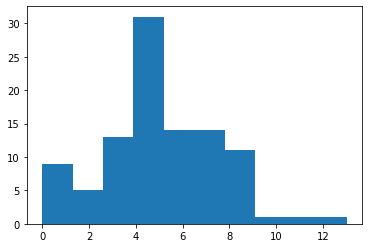

In [7]:
a = default_rng()
a_noise = a.poisson(5 * np.ones(100))
plt.hist(a_noise)

In [68]:
f = h5py.File('data/P_array/sample_64_64_64/detSpacing_0.4_dpts_5/backup4/Intersecting_Length_64_64_64.h5', 'r')
f_data_array = np.array(f['P_array'][...])
print(f_data_array.shape)

(5, 3, 28835840)


In [69]:
# f_data_array = np.load('data/P_array/sample_64_64_64/detSpacing_0.4_dpts_5/backup/Intersecting_Length_64_64_64.npy')
# print(f_data_array.shape)

In [5]:
def rotate(arr, theta, dev):
    """
    This function rotates the grid concentration with dimension: (n_element, sample_height_n, sample_size_n, sample_size_n)
    The rotational axis is along dim 1 of the grid
    
    Parameters
    ----------
    arr : torch tensor
        grid concentration
        
    theta : float
        rotation angle in radians (clockwise)
    
    dev : string
        specify "cpu" or the cuda diveice (ex: cuda:0)


    Returns
    -------
    q : torch tensor
        the rotated grid concentration

    """
    
    m0 = tc.tensor([tc.cos(theta), -tc.sin(theta), 0.0], device=dev)
    m1 = tc.tensor([tc.sin(theta), tc.cos(theta), 0.0], device=dev)
    m = tc.stack([m0, m1]).view(1, 2, 3)
    m = m.repeat([arr.shape[0], 1, 1])
    
    g = F.affine_grid(m, arr.shape)
    q = F.grid_sample(arr, g, padding_mode='border')
    
    return q


In [6]:
def attenuation_3d(src_path, theta_st, theta_end, n_theta, sample_height_n, sample_size_n,
                sample_size_cm, this_aN_dic, probe_energy, dev):
 
    
    n_element = len(this_aN_dic)
    theta_ls = - tc.linspace(theta_st, theta_end, n_theta + 1)[:-1]
    grid_concentration = tc.tensor(np.load(src_path)).float().to(dev)
    aN_ls = np.array(list(this_aN_dic.values()))
    probe_attCS_ls = tc.tensor(xlib_np.CS_Total(aN_ls, probe_energy).flatten()).float().to(dev)
    
    att_exponent_acc_map = tc.zeros((len(theta_ls), sample_height_n, sample_size_n, sample_size_n+1), device=dev)
    for i , theta in enumerate(theta_ls):
        theta = tc.tensor(theta,  device=dev)
        concentration_map_rot = rotate(grid_concentration, theta, dev)
        for j in range(n_element):
            lac_single = concentration_map_rot[j] * probe_attCS_ls[j]
            lac_acc = tc.cumsum(lac_single, axis=2)
            lac_acc = tc.cat((tc.zeros((sample_height_n, sample_size_n, 1), device=dev), lac_acc), dim = 2)
            att_exponent_acc = lac_acc * (sample_size_cm / sample_size_n) 
            att_exponent_acc_map[i,:,:,:] += att_exponent_acc

    attenuation_map_flat = tc.exp(-(att_exponent_acc_map[:,:,:,:-1])).view(n_theta, sample_height_n * sample_size_n * sample_size_n).float().to(dev)
    transmission = tc.exp(-att_exponent_acc_map[:,:,:,-1]).view(n_theta, sample_height_n * sample_size_n).float().to(dev)
    
    return attenuation_map_flat, transmission

In [7]:
src_path = "./data/sample8_size_64_pad/nElements_2/grid_concentration.npy"
theta_st = 0.
theta_end = 2 * np.pi
n_theta = 200
sample_height_n = 64
sample_size_n = 64
sample_size_cm = 0.01
this_aN_dic = {"Ca": 20, "Sc": 21}
probe_energy = np.array([20.0])
dev = "cpu"

In [8]:
attenuation_map_flat, transmission = attenuation_3d(src_path, theta_st, theta_end, n_theta, sample_height_n, sample_size_n,
                                                    sample_size_cm, this_aN_dic, probe_energy, dev)

/home/hpphappy/anaconda3/envs/joint_XRF_XRT/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/home/hpphappy/anaconda3/envs/joint_XRF_XRT/lib/python3.7/site-packages/torch/nn/functional.py:3447: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/hpphappy/anaconda3/envs/joint_XRF_XRT/lib/python3.7/site-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the document

In [ ]:
def create_XRT_data_3d(src_path, theta_st, theta_end, n_theta, sample_height_n, sample_size_n,
                         sample_size_cm, this_aN_dic, probe_energy, probe_cts, save_path, save_fname, theta_sep, Poisson_noise, dev):
 
    XRT_data = probe_cts * attenuation_3d(src_path, theta_st, theta_end, n_theta, sample_height_n, sample_size_n,
                sample_size_cm, this_aN_dic, probe_energy, dev)[1]
    
    if Poisson_noise == True:
        random_noise_generator = default_rng()
        XRT_data = random_noise_generator.poisson(XRT_data)
    
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    else:
        pass    
    
    if theta_sep == True:       
        for this_theta_idx in tqdm(range(n_theta)):
            np.save(os.path.join(save_path, save_fname +'_{}'.format(this_theta_idx)), XRT_data[this_theta_idx])
    
    else:
        np.save(os.path.join(save_path, save_fname), XRT_data.cpu())
    
    return XRT_data

In [16]:
# with h5py.File("./data/P_array/sample_44_44_20/detSize_2.4_detSpacing_1.2_dpts_5/backup/Intersecting_Length_44_44_20.h5", "r") as f:
#     P_array_1 = f['P_array']

# with h5py.File("./data/P_array/sample_5_5_5_n/detSize_2.4_detSpacing_1.2_dpts_5/Intersecting_Length_5_5_5.h5", "r") as f:
#     P_array_2 = f['P_array'][...]

with h5py.File("./data/P_array/sample_44_44_20_n/Dis_0.05_detSize_2.4_manual_dpts_4/Intersecting_Length_44_44_20.h5", "r") as f:
    P_array_2 = f['P_array'][...]
    

20331
(44, 44)


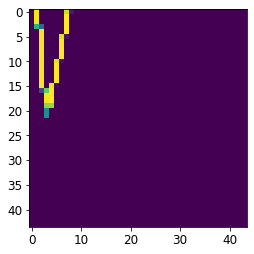

In [21]:
n_dia = 78
voxel_idx = 44 * 22 + 3 + 44*44*10
print(voxel_idx)

np.set_printoptions(threshold=sys.maxsize)

sample = np.zeros(44*44*20)
for det_idx in range(4):
    source_voxel = P_array_2[det_idx, 0, voxel_idx*n_dia: (voxel_idx+1)*n_dia]
    int_voxel = P_array_2[det_idx, 1, voxel_idx*n_dia: (voxel_idx+1)*n_dia]
    int_length = P_array_2[det_idx, 2, voxel_idx*n_dia: (voxel_idx+1)*n_dia]
   
    sample[int_voxel.astype(np.int)] = int_length


sample = np.reshape(sample, (20, 44, 44))
sample_sum_0 = np.sum(sample, axis=0)
print(sample_sum_0.shape)
plt.imshow(sample_sum_0)

(20, 44)


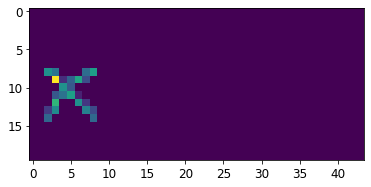

In [18]:
sample = np.reshape(sample, (20, 44, 44))
sample_sum_0 = np.sum(sample, axis=1)
print(sample_sum_0.shape)
plt.imshow(sample_sum_0)

(20, 44)


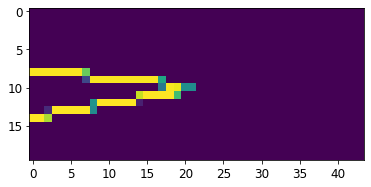

In [19]:
sample = np.reshape(sample, (20, 44, 44))
sample_sum_0 = np.sum(sample, axis=2)
print(sample_sum_0.shape)
plt.imshow(sample_sum_0)

20350
(44, 44)


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


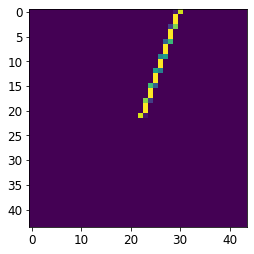

In [3]:
n_dia = 78
voxel_idx = 44 * 22 + 22 + 44*44*10
print(voxel_idx)
det_idx = 2

np.set_printoptions(threshold=sys.maxsize)

source_voxel = P_array_2[det_idx, 0, voxel_idx*n_dia: (voxel_idx+1)*n_dia]
int_voxel = P_array_2[det_idx, 1, voxel_idx*n_dia: (voxel_idx+1)*n_dia]
int_length = P_array_2[det_idx, 2, voxel_idx*n_dia: (voxel_idx+1)*n_dia]

# print(source_voxel)
# print(int_voxel)
# print(int_length)

sample = np.zeros(44*44*20)
sample[int_voxel.astype(np.int)] = int_length

sample = np.reshape(sample, (20, 44, 44))
sample_sum_0 = np.sum(sample, axis=0)
print(sample_sum_0.shape)
plt.imshow(sample_sum_0)

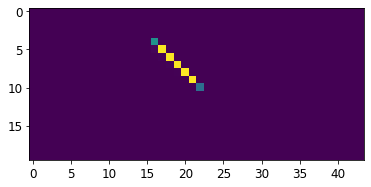

In [191]:
sample_sum_1 = np.sum(sample, axis=1)
plt.imshow(sample_sum_1)

990
(44, 44)


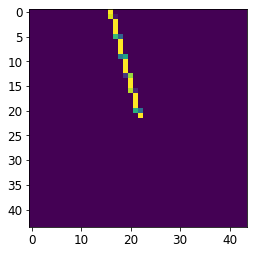

In [180]:
n_dia = 71
voxel_idx = 44 * 22 + 22 + 44*44*0
# voxel_idx = 5

print(voxel_idx)
det_idx = 1

np.set_printoptions(threshold=sys.maxsize)
source_voxel = P_array_2[det_idx, 0, voxel_idx*n_dia: (voxel_idx+1)*n_dia]
int_voxel = P_array_2[det_idx, 1, voxel_idx*n_dia: (voxel_idx+1)*n_dia]
int_length = P_array_2[det_idx, 2, voxel_idx*n_dia: (voxel_idx+1)*n_dia]

# print(source_voxel)
# print(int_voxel)
# print(int_length)

sample = np.zeros(44*44*20)
sample[int_voxel.astype(np.int)] = int_length

sample = np.reshape(sample, (20, 44, 44))
sample_sum_0 = np.sum(sample, axis=0)
print(sample_sum_0.shape)
plt.imshow(sample_sum_0)

990
(44, 44)


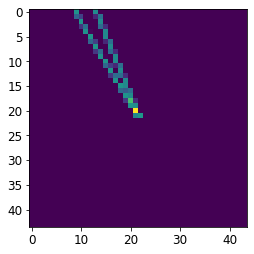

In [170]:
n_dia = 71
voxel_idx = 44 * 22 + 22 + 44*44*0
# voxel_idx = 5

print(voxel_idx)
det_idx = 1

np.set_printoptions(threshold=sys.maxsize)
source_voxel = P_array_2[det_idx, 0, voxel_idx*n_dia: (voxel_idx+1)*n_dia]
int_voxel = P_array_2[det_idx, 1, voxel_idx*n_dia: (voxel_idx+1)*n_dia]
int_length = P_array_2[det_idx, 2, voxel_idx*n_dia: (voxel_idx+1)*n_dia]

# print(source_voxel)
# print(int_voxel)
# print(int_length)

sample_2 = np.zeros(44*44*20)
sample_2[int_voxel.astype(np.int)] = int_length

sample_2 = np.reshape(sample_2, (20, 44, 44))
sample_sum_0_2 = np.sum(sample_2, axis=0) + sample_sum_0
print(sample_sum_0_2.shape)
plt.imshow(sample_sum_0_2)

In [124]:
a = np.zeros(5)
b = np.array([1,3,5])
pos = np.array([0,2,4])
a[pos] = b
print(a)

[1. 0. 3. 0. 5.]


In [171]:
a = np.ones((3,4))
a * 0.1

array([[0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1]])

In [5]:
tc.arange(2,10,1)

tensor([2, 3, 4, 5, 6, 7, 8, 9])

In [2]:
def find_lines_roi_idx_from_dataset(data_path, f_XRF_data, element_lines_roi):
    XRF_data = h5py.File(os.path.join(data_path, f_XRF_data), 'r')
    channel_names = XRF_data['exchange/elements'][...]
    channel_names = np.array([str(channel_name, 'utf-8') for channel_name in channel_names])

    element_lines_roi_idx = np.zeros(len(element_lines_roi)).astype(np.int)
    for i, element_line_roi in enumerate(element_lines_roi):
        if element_line_roi[1] == "K":
            channel_name_roi = element_line_roi[0]
        else:
            channel_name_roi = element_line_roi[0] + "_" + element_line_roi[1]
        element_line_idx = np.argwhere(channel_names == channel_name_roi)
        element_lines_roi_idx[i] = element_line_idx
        
    XRF_data.close()
    return element_lines_roi_idx  

In [3]:
data_path = './data/Xtal1_align1_adjusted1_ds4'    # the folder where the data file is in
f_XRF_data = 'xtal1_xrf-roi-plus'    # the aligned channel data file output from XRFtomo 
element_lines_roi = np.array([['Al', 'K'], ['Si', 'K'], ['Fe', 'K'], ['Cu', 'K']])

In [4]:
find_lines_roi_idx_from_dataset(data_path, f_XRF_data, element_lines_roi)

array([ 0,  1, 11, 14])

In [2]:
a = [tc.ones(2,6), tc.ones(2,6)]
d = tc.cat(a, axis=-1)
print(d.shape)

torch.Size([2, 12])
